In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.stats import norm
from scipy.integrate import odeint
name = "results1.txt"

M = 20 # число мод
N = 1 # 40000 число генераций выборки
n = 2 * M + 2 # размерность вектора состояния
dk = math.pi / (M + 1.)
timeStepsInOne = 100 #100
timeMax = 200 #200
timeSteps = timeStepsInOne * timeMax + 1
time = np.linspace(0, timeMax, timeSteps)

epsilon0 = 1.
epsilon = epsilon0
h = 0.05 #Должно быть 0.05?
condition = 1e-6

def createOperator(n, sigmaZFlag = False, sigmaPlusFlag = False, sigmaMinusFlag = False): #offset down
    matrix = np.zeros(n*n, dtype = np.complex).reshape(n, n)
    for i in np.arange(n):
        for j in np.arange(n):
            a = np.zeros(n)
            b = np.zeros(n)     
            a[i] = 1
 
            if (sigmaZFlag):
                b[j] = (-1) ** j             
            elif (sigmaPlusFlag and j % 2 != 0):
                b[j - 1] = 1
            elif (sigmaMinusFlag and j % 2 == 0):
                b[j + 1] = 1
                
            matrix[i][j] = np.dot(a, b)
    return matrix

def createB(m, n):
    matrix = np.zeros(m*n*n, dtype = np.complex).reshape(m, n, n)
    
    for k in np.arange(m):
        for i in np.arange(n):
            for j in np.arange(n):
                a = np.zeros(n)
                b = np.zeros(n)
                
                a[i] = 1

                if (j == 2 * k + 2):
                    b[0] = 1
                elif (j == 2 * k + 3):
                    b[1] = 1
                    
                matrix[k][i][j] = np.dot(a, b)
    return matrix



sigmaZ = createOperator(n, sigmaZFlag = True)#np.array([1, 0, 0, -1], dtype = np.complex).reshape(2, 2)
sigmaPlus = createOperator(n, sigmaPlusFlag = True)#np.array([0, 1, 0, 0], dtype = np.complex).reshape(2, 2)
sigmaMinus = createOperator(n, sigmaMinusFlag = True)#np.array([0, 0, 1, 0], dtype = np.complex).reshape(2, 2)
b = createB(M, n)
sigma = np.dot(sigmaPlus, sigmaMinus) 


# Изначально спин направлен вниз
psi0 = np.zeros(n, dtype = np.complex)#psi0 = np.array([0., 1.], dtype = np.complex)
psi0[1] = 1.

def f(t):
    return .1*np.cos(t)

def zFunction(omega, z, c, t):
    return np.dot (c, np.exp(1.j * omega * t, dtype = np.complex) * z.conjugate())

def HSys(t):
    return epsilon * sigma + sigmaPlus * f(t) + sigmaMinus * f(t).conjugate() 

def H(omega, z, c, t):
    return HSys(t) +\
        np.dot( sigmaPlus, (np.array([b[i] * c[i] for i in np.arange(M)]).sum(axis = 0)) ) +\
        np.dot( sigmaMinus, (np.array([b[i].T * c[i].conjugate() for i in np.arange(M)]).sum(axis = 0)) ) +\
        sigmaMinus * (zFunction(omega, z, c, t)) +\
        np.array([omega[i] * np.dot(b[i].T, b[i]) for i in np.arange(M)]).sum(axis = 0)

def getShredingerEq(omega, z, c):
    def ShredingerEq(psi, t):
        return -1.j * np.dot(H(omega, z, c, t), psi)
    return ShredingerEq

# implicitMidpointMethod is a mutable function
def implicitMidpointMethod(A, y0, numIterations, step): #y0 == y[0]
    y = np.zeros(numIterations * y0.size, dtype = np.complex).reshape(numIterations, y0.size)
    y[0] = y0
    
    N = y[:,0].size - 1
    yMid = y[0]
    
    for n in np.arange(N):
        while(True):
            y[n+1] = y[n] + step*np.array(A(yMid, step*(n + .5)))
            yMidNew = (y[n+1] + y[n]) / 2 
            if(scipy.spatial.distance.euclidean(yMid, yMidNew) < condition):
                break
            yMid = yMidNew     
    return y
# квадратичная форма в каждый момент вр. (оператор в обкладках из состояний)
qfProj0 = lambda A, x : (np.dot(x[:, :2].conjugate(), A[:2, :2]) * x[:, :2]).sum(axis = 1)
# норма вектора
normProj0 = lambda x : (x[:, :2].conjugate() * x[:, :2]).sum(axis = 1)


# параметры модели
omega = epsilon + 2. * h * np.cos(dk*np.arange(1, M + 1))
c = np.sqrt(2. / np.pi * dk) * h * np.sin(dk*np.arange(1, M + 1))


psiAverageProj0 = np.zeros(timeSteps, dtype = np.complex)
sigmaAverageProj0 = np.zeros(timeSteps, dtype = np.complex)

for i in np.arange(N):
    print i
    #генерируем вектор z: z_i = (x + j*y)/sqrt(2); x, y из N(0, 1) 
    ##z = (np.random.normal(size=M) + 1.j * np.random.normal(size=M)) / np.sqrt(2)
    z = np.zeros(M, dtype = np.complex)
    ShredingerEq = getShredingerEq(omega, z, c)
        
    psi = implicitMidpointMethod(ShredingerEq, psi0, timeSteps, time[1] - time[0])
    sigmaAverageProj0 += qfProj0(sigma, psi)
    psiAverageProj0 += normProj0(psi)
    
sigmaAverageProj0 /= psiAverageProj0

resultsFile = open("results.txt", "w")
resultsFile.write('time    value\n')
for i in np.arange(time.size):
    resultsFile.write(`time[i]` + ' ' + `sigmaAverageProj0[i].real` + '\n')
resultsFile.close()

resultsFile = open(name, "w")
for i in np.arange(time.size):
    resultsFile.write(`sigmaAverageProj0[i].real` + '\n')
resultsFile.close()

0


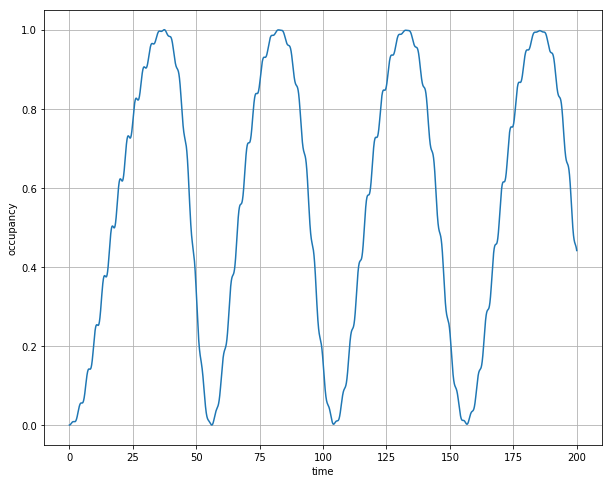

In [5]:
fig = plt.figure(figsize=(10,8))
pl = fig.add_subplot(111)
pl.set_xlabel("time")
pl.set_ylabel("occupancy")
pl.grid(1)
pl.grid(True)

pl.plot(time, sigmaAverageProj0)

plt.show()